## Análise séries temporais: Série histórica da produção de trigo nos Estados Unidos no período de 1866 - 2021.

Fonte dos dados: https://www.ers.usda.gov/data-products/wheat-data/

## Resumo: Este trabalho visa analisar a série histórica de produção de trigo dos EUA no período de 1866 a 2021 e se utiliza de métodos autoregressivos para modelar os dados. Como métrica de desempenho do modelo foi calculado RMSE e comparado com o modelo desenvolvido utilizando o pacote prophet (Facebook) de maneira automatica. 

Breve resumo dos parâmetros de entrada para um modelo de autoregressão ARIMA.
AR: Autoregressão: o grau de observações atrasadas levadas em conta na construção do modelo.
I: Integrado. O número de diferenciações nas observações originais para tornar a série estacionária.
MA: Média móvel. A janela da média móvel utilizada.

## Carrega os pacotes necessários para análise

In [1]:
import pandas as pd
from datetime import datetime
from pandas_ods_reader import read_ods
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib as m
import numpy as np
import random
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.stats.stattools import jarque_bera
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
m.style.use('ggplot')
%matplotlib inline

## Conjunto de dados

In [2]:
df = read_ods('data.ods', sheet = 'Trigo-EUA');print('Amostra de registros: \n', df.sample(10), '\n Formato dos dados: \n', df.shape)

Amostra de registros: 
         ano  produção de trigo (milhares de bushels)
149  2015.0                                2061939.0
37   1903.0                                 663115.0
99   1965.0                                1315600.0
148  2014.0                                2026310.0
72   1938.0                                 919913.0
3    1869.0                                 289526.0
71   1937.0                                 873914.0
90   1956.0                                1005000.0
32   1898.0                                 768148.0
124  1990.0                                2729778.0 
 Formato dos dados: 
 (156, 2)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ano                                      156 non-null    float64
 1   produção de trigo (milhares de bushels)  156 non-null    float64
dtypes: float64(2)
memory usage: 2.6 KB


In [4]:
df.describe()

,ano,produção de trigo (milhares de bushels)
count,156.000000,1.560000e+02
mean,1943.500000,1.219164e+06
std,45.177428,7.156641e+05
min,1866.000000,1.697030e+05
25%,1904.750000,6.286298e+05
50%,1943.500000,9.626905e+05
75%,1982.250000,1.896871e+06
max,2021.000000,2.785357e+06


In [5]:
# Transformações nos títulos das colunas
df.columns = ['ano','producao']
df.columns

Index(['ano', 'producao'], dtype='object')

In [6]:
# Definindo o ano como index do dataframe e o formato dos dados das colunas
df.ano = df.ano.astype(int)
df = df.set_index('ano')
df.producao =  df.producao.astype(float)

In [7]:
#Tópico de suavização da série histórica pela média móvel de 5.
values = df.producao
window_size = 4
moving_avg = values.rolling(window_size).mean()
df['producao'] = moving_avg

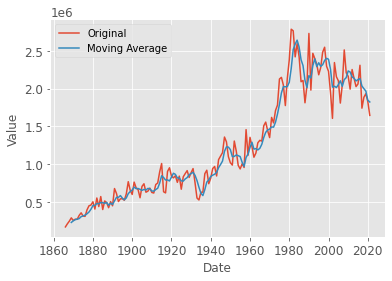

In [8]:
plt.plot(df.index, values, label='Original')
plt.plot(df.index, df.producao, label='Moving Average')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [9]:
df = df.dropna()

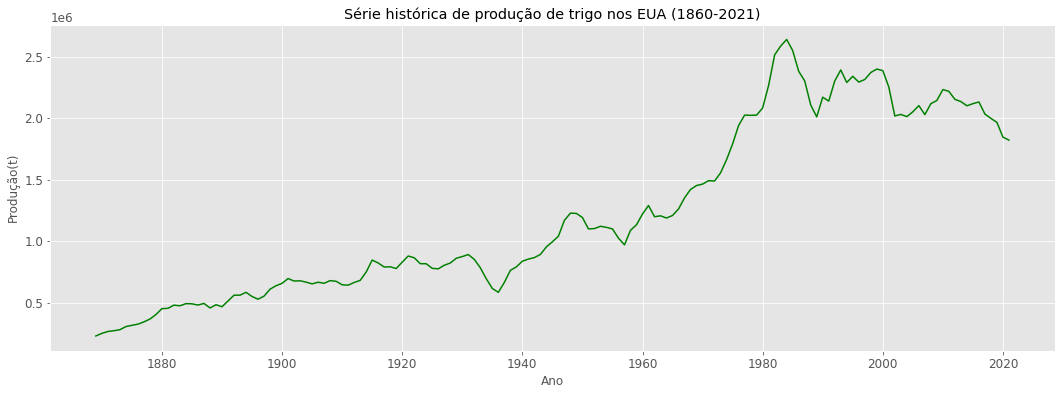

In [10]:
# Plotagem da série histórica de produção suavizada
ax = df.producao.plot(color='g', figsize = (18,6))
plt.xlabel('Ano')
plt.ylabel('Produção(t)')
plt.title('Série histórica de produção de trigo nos EUA (1860-2021)')
plt.show()

## Teste de estacionariedade dos dados

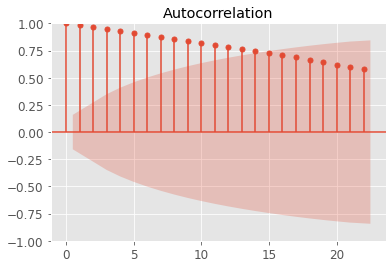

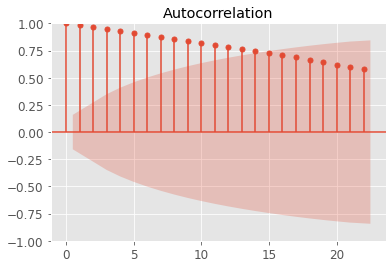

In [11]:
#verificando autocorrelação dos dados
plot_acf(df.producao)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

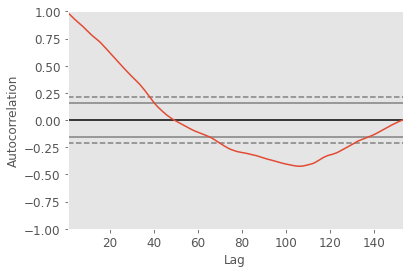

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.producao)

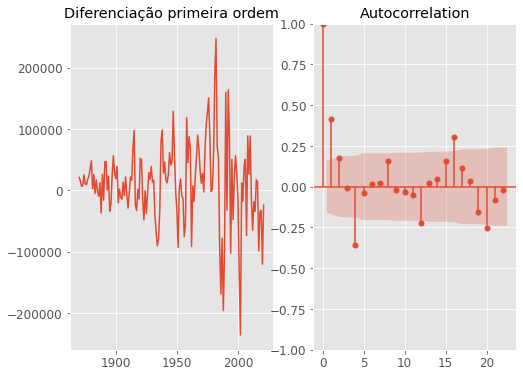

In [13]:
# os dados analisados tem alto grau de correlação até em ordens elevadas. Adiante será avaliado os graus de correlações a serem utilizados no modelo.
# a seguir faz-se a diferenciação dos valores para identificar qual de diferenciação torna os dados estacionários e definir o valor de d.

f = plt.figure(figsize = (8,6))
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação primeira ordem')
ax1.plot(df.producao.diff())

ax2 = f.add_subplot(122)
plot_acf(df.producao.diff().dropna(), ax = ax2)
plt.show()

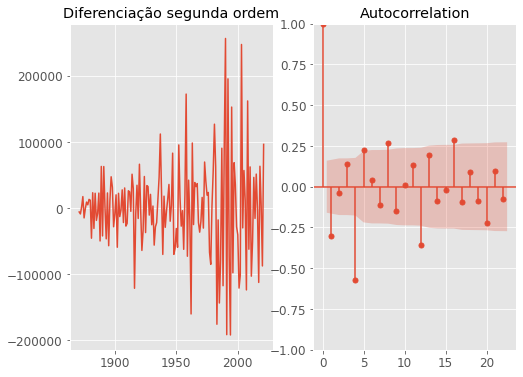

In [14]:
# plot da segunda diferenciação
f = plt.figure(figsize = (8,6))
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação segunda ordem')
ax1.plot(df.producao.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df.producao.diff().diff().dropna(), ax = ax2)
plt.show()

In [15]:
# pelo grafico acima já verifica-se os dados nao-autocorrelacionados, o que nos faz definir d=2. 
# Há também o método do teste de estacionariedade definido abaixo pelo teste dickey-fuller
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

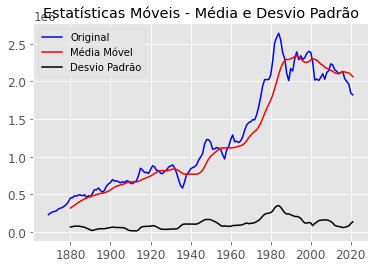


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.086387
Valor-p                           0.720470
Número de Lags Consideradas      13.000000
Número de Observações Usadas    139.000000
Valor Crítico (1%)               -3.478294
Valor Crítico (5%)               -2.882568
Valor Crítico (10%)              -2.577983
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [16]:
# Método alternativo para verificar se a série é estacionária
testa_estacionaridade(df.producao)

In [17]:
# o modelo autoregressivo exige dados estacionários, portanto será calculado o diferencial dos dados e verificado novamente.
df['diff_1'] = df.diff(periods=1)
df = df.dropna()
df.head()

,producao,diff_1
ano,,
1870,250276.25,21181.50
1871,265527.00,15250.75
1872,271829.50,6302.50
1873,279930.75,8101.25
1874,305352.25,25421.50


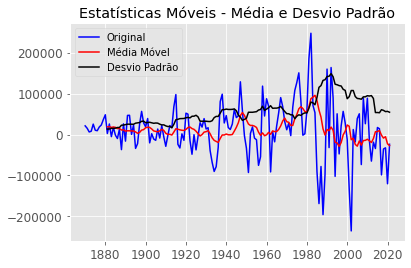


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.630301
Valor-p                           0.086895
Número de Lags Consideradas      12.000000
Número de Observações Usadas    139.000000
Valor Crítico (1%)               -3.478294
Valor Crítico (5%)               -2.882568
Valor Crítico (10%)              -2.577983
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [18]:
# Verifica se a série é estacionária
testa_estacionaridade(df.diff_1)

In [19]:
# o modelo autoregressivo exige dados estacionários, portanto será calculado o diferencial dos dados e verificado novamente.
df['diff_2'] = df.diff_1.diff(periods=1)
df = df.dropna()
df.head()

,producao,diff_1,diff_2
ano,,,
1871,265527.00,15250.75,-5930.75
1872,271829.50,6302.50,-8948.25
1873,279930.75,8101.25,1798.75
1874,305352.25,25421.50,17320.25
1875,315814.00,10461.75,-14959.75


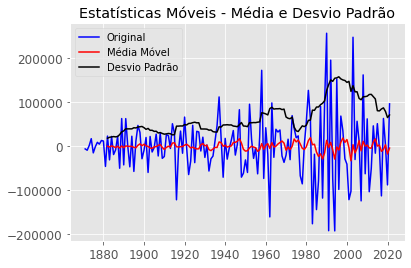


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -6.114992e+00
Valor-p                         9.139986e-08
Número de Lags Consideradas     1.300000e+01
Número de Observações Usadas    1.370000e+02
Valor Crítico (1%)             -3.479007e+00
Valor Crítico (5%)             -2.882878e+00
Valor Crítico (10%)            -2.578149e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [20]:
# Verifica se a série é estacionária. O resultado mostra que a séria gerada é estacionária. 
#Portanto, confirmando o primeiro método de análise, tem-se d=2

testa_estacionaridade(df.diff_2)

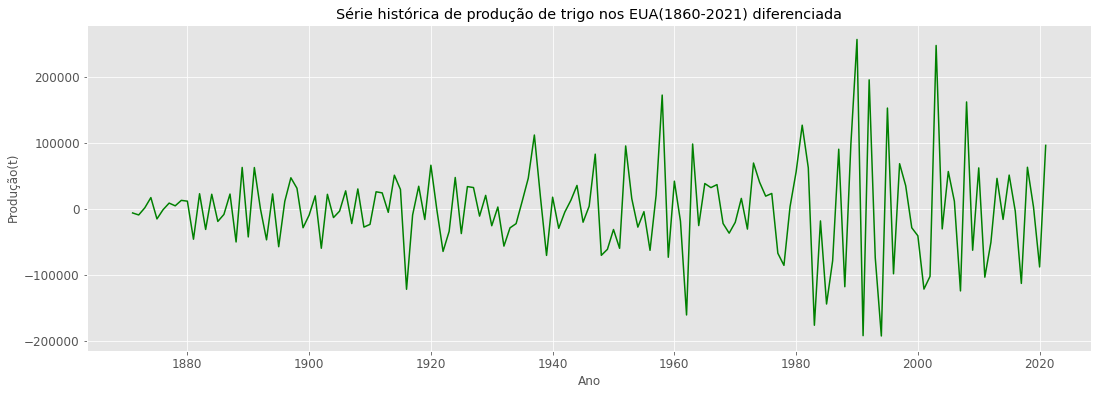

In [21]:
# Plotagem da séries histórica diferenciada
ax = df['diff_2'].plot(color='g', figsize = (18,6))
plt.xlabel('Ano')
plt.ylabel('Produção(t)')
plt.title('Série histórica de produção de trigo nos EUA(1860-2021) diferenciada')
plt.show()

In [22]:
df.head()

,producao,diff_1,diff_2
ano,,,
1871,265527.00,15250.75,-5930.75
1872,271829.50,6302.50,-8948.25
1873,279930.75,8101.25,1798.75
1874,305352.25,25421.50,17320.25
1875,315814.00,10461.75,-14959.75


Para determinação do valor de p, verificamos os dados da diferenciação e escolhemos os mais significativos. Neste caso, adotamos p=15

Para determinação do valor de q, adotamos q=0 pois os dados já foram suavizados anteriormente pela média móvel

O modo visual de determinação do modelo mais adequado para Arima indica order=(15,2,0)

In [49]:
arima_model = ARIMA(df.producao.values, order = (15,2,0))
modelo_visual = arima_model.fit()
modelo_visual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:                ARIMA(15, 2, 0)   Log Likelihood               -1824.773
Date:                Thu, 25 May 2023   AIC                           3681.545
Time:                        11:20:37   BIC                           3729.608
Sample:                             0   HQIC                          3701.072
                                - 151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4226      0.076     -5.534      0.000      -0.572      -0.273
ar.L2         -0.3279      0.080     -4.121      0.000      -0.484      -0.172
ar.L3         -0.2931      0.076     -3.836      0.000      -0.443      -0.143
ar.L4         -0.7869      0.075    -10.495      0.000      -0.934      -0.640
ar.L5         -0.3921      0.079     -4.988      0.000      -0.546      -0.238
ar.L6         -0.2799      0.120     -2.329      0.020      -0.516      -0.044
ar.L7         -0.2869      0.096     -2.988      0.003      -0.475      -0.099
ar.L8         -0.4881      0.100     -4.864      0.000      -0.685      -0.291
ar.L9         -0.2464      0.104     -2.372      0.018      -0.450      -0.043
ar.L10        -0.2317      0.121     -1.910      0.056      -0.470       0.006
ar.L11        -0.1452      0.124     -1.169      0.242      -0.389       0.098
ar.L12        -0.4094      0.091     -4.523      0.000      -0.587      -0.232
ar.L13        -0.1456      0.103     -1.410      0.159      -0.348       0.057
ar.L14        -0.1801      0.105     -1.709      0.087      -0.387       0.026
ar.L15        -0.0206      0.114     -0.181      0.856      -0.244       0.203
sigma2      2.524e+09   1.71e-11   1.48e+20      0.000    2.52e+09    2.52e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.29
Prob(Q):                              0.83   Prob(JB):                         0.02
Heteroskedasticity (H):               3.65   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+37. Standard errors may be unstable.
"""

In [24]:
y_pred = modelo_visual.predict()[1:]

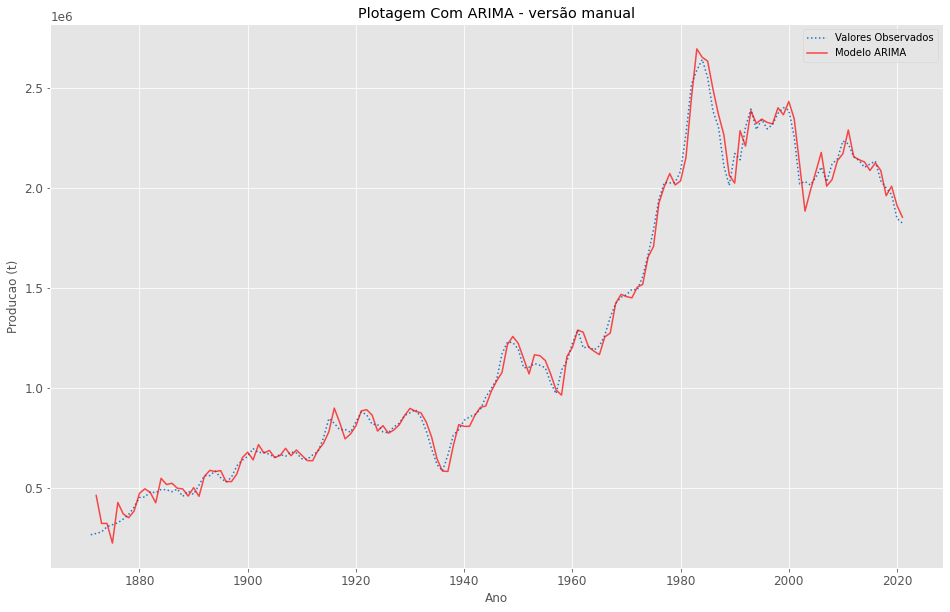

In [25]:
f = plt.figure(figsize = (16,10))

plt.plot(df.producao.index, df.producao.values, label = 'Valores Observados', color = '#2574BF', linestyle='dotted')
plt.plot(df.producao[1:].index,
         y_pred,
         label = 'Modelo ARIMA', 
         alpha = 0.7, 
         color = 'red')
plt.title('Plotagem Com ARIMA - versão manual')
plt.xlabel('Ano')
plt.ylabel('Producao (t)')
plt.legend()
plt.show()

In [26]:
# Função para calcular a acuracia
def performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

In [27]:
performance(df.producao[1:], y_pred)

MSE das previsões é 2755990362.78
RMSE das previsões é 52497.53
MAPE das previsões é 0.04


## A seguir foi feito um modelo ARIMA com os mesmos parametros anteriormente definidos porém em um contexto de separação dos dados em dados de treino e de teste para calcular o erro do modelo em dados ainda nao vistos anteriormente a partir da função forecast(), que prevê o próximo valor da série.

In [28]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(X, arima_order):
    
    # Prepara os dados
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Previsões
    predictions = list()
    
    # Loop
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        obs = test[t]
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    # Calcula o erro do modelo
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse, test, predictions

predicted=2331792.561165, expected=2139684.000000
predicted=2142741.388648, expected=2303333.250000


C:\Users\fluzd\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=2376517.233040, expected=2393288.750000
predicted=2306095.138114, expected=2291089.500000
predicted=2329989.907145, expected=2341731.750000
predicted=2347496.226659, expected=2294379.250000
predicted=2296056.536457, expected=2315635.750000
predicted=2423707.582477, expected=2372220.750000
predicted=2376226.582414, expected=2400428.750000
predicted=2433663.059293, expected=2388121.750000
predicted=2360396.827605, expected=2254618.500000
predicted=2124794.991668, expected=2019257.750000
predicted=1846768.472632, expected=2031476.500000
predicted=1986834.073488, expected=2013634.000000
predicted=2072355.692337, expected=2052602.000000
predicted=2218999.988342, expected=2103236.500000
predicted=2006487.960058, expected=2029904.750000
predicted=2011574.048568, expected=2118681.250000
predicted=2144550.751988, expected=2145079.500000
predicted=2151131.023211, expected=2233731.250000
predicted=2299163.574227, expected=2219237.000000
predicted=2154166.033976, expected=2154339.750000


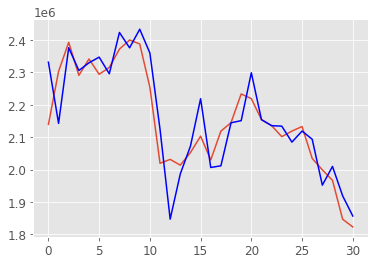

In [29]:
rmse, test, predictions = avalia_modelo_arima(df.producao.values, (15,2,0))
print('RMSE: ', rmse)

plt.plot(test)
plt.plot(predictions, color='blue')
plt.show()

## Nota-se que o erro médio é maior para dados novos na série do que para os dados utilizados para o fit do modelo.

## Formulação alternativa para busca otimizada dos parâmetros do modelo: Grid Search para os parâmetros p, d e q

Dividindo o dataset em dados de treino e dados de teste
Foi adotada a proporção de dados para treino/teste como 80:20 

In [30]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(dataset, p_values, d_values, q_values):
    
    # Ajusta o tipo dos dados
    dataset = dataset.astype('float32')
    
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, test, predictions = avalia_modelo_arima(dataset, order)
                    
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE = %.3f' % (order, rmse))
                    # plot previsões e valores originais
                    plt.plot(test)
                    plt.plot(predictions, color='blue')
                    plt.show()
                except:
                    continue

    print('\nMelhor Modelo ARIMA %s RMSE = %.3f' % (best_cfg, best_score))

In [31]:
# Valores para o grid
p_values = range(0,20)
d_values = [0, 1, 2, 3, 4] 
q_values = [0, 1, 2, 3, 4, 5] 

In [32]:
df.head()

,producao,diff_1,diff_2
ano,,,
1871,265527.00,15250.75,-5930.75
1872,271829.50,6302.50,-8948.25
1873,279930.75,8101.25,1798.75
1874,305352.25,25421.50,17320.25
1875,315814.00,10461.75,-14959.75


In [ ]:
# esta célula pode demorar para ser executada.
# Testando o melhor valor de p, d e q
avalia_melhor_arima(df.producao.values, p_values, d_values, q_values)

In [ ]:
# pelo método grid search utilizado acima, tem-se que o melhor modelo encontrado foi 0,1,4 e será plotado abaixo
modelo_arima = ARIMA(df.producao.values, order = (0,1,4))
model = modelo_arima.fit()
print(model.summary())

In [43]:
# Valores do modelo do treino
arima_predict = model.predict()

In [44]:
y_predict = arima_predict[1:];

In [37]:
#forecast = model.forecast();forecast

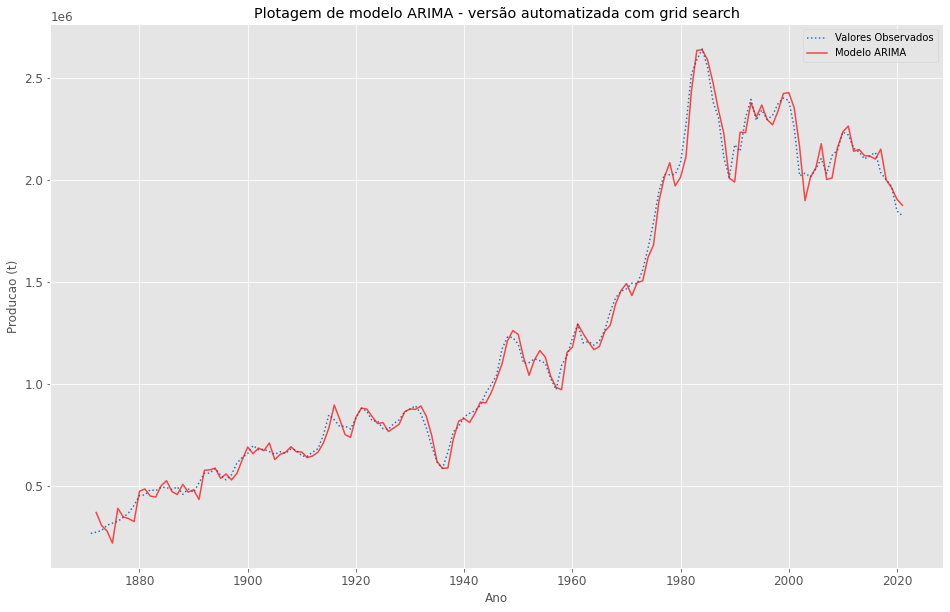

In [45]:
f = plt.figure(figsize = (16,10))
plt.plot(df.producao.index, df.producao.values, label = 'Valores Observados', color = '#2574BF', linestyle='dotted')
plt.plot(df.producao[1:].index,
         y_predict,
         label = 'Modelo ARIMA', 
         alpha = 0.7, 
         color = 'red')
plt.title('Plotagem de modelo ARIMA - versão automatizada com grid search')
plt.xlabel('Ano')
plt.ylabel('Producao (t)')
plt.legend()
plt.show()

In [46]:
# Calcular a acuracia para os dados de treino
performance(df.producao[1:], y_predict)

MSE das previsões é 2529693185.53
RMSE das previsões é 50296.06
MAPE das previsões é 0.04


predicted=2258901.356931, expected=2139684.000000


C:\Users\fluzd\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=2231169.141795, expected=2303333.250000
predicted=2374667.585040, expected=2393288.750000
predicted=2308842.832736, expected=2291089.500000
predicted=2370559.909670, expected=2341731.750000
predicted=2293217.671827, expected=2294379.250000
predicted=2263699.745836, expected=2315635.750000
predicted=2338791.146496, expected=2372220.750000
predicted=2429157.890370, expected=2400428.750000
predicted=2423971.934789, expected=2388121.750000
predicted=2349758.722110, expected=2254618.500000


C:\Users\fluzd\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=2157540.966847, expected=2019257.750000
predicted=1883729.819299, expected=2031476.500000
predicted=2007860.448503, expected=2013634.000000
predicted=2060356.125777, expected=2052602.000000
predicted=2179580.926446, expected=2103236.500000
predicted=1999467.934713, expected=2029904.750000
predicted=2001677.929735, expected=2118681.250000
predicted=2161776.808526, expected=2145079.500000
predicted=2237256.819910, expected=2233731.250000
predicted=2258787.903426, expected=2219237.000000
predicted=2137316.660405, expected=2154339.750000
predicted=2153412.764151, expected=2135855.000000
predicted=2118103.446413, expected=2101676.750000
predicted=2110836.442773, expected=2118883.750000
predicted=2102550.239373, expected=2132972.750000
predicted=2154282.409836, expected=2034455.500000
predicted=1994232.304338, expected=1999167.000000
predicted=1960947.020869, expected=1966686.500000
predicted=1909486.094613, expected=1846531.500000
predicted=1877329.995112, expected=1822745.000000


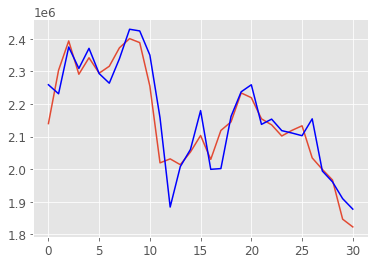

In [47]:
# A seguir foi feito um modelo ARIMA com os mesmos parametros anteriormente definidos porém em um contexto de separação dos dados
# em dados de treino e de teste para calcular o erro do modelo em dados ainda nao vistos anteriormente.

# dividindo os dados em dados de treino e dados de teste
X = df.producao.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# validação dos dados
for t in range(len(test)):
    modelo = ARIMA(history, order=(0,1,4))
    model0_fit = modelo.fit()
    output = model0_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
# avaliação das previsões
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot previsões (azul) e valores originais
plt.plot(test)
plt.plot(predictions, color='blue')
plt.show()

# Entre os dois modelos desenvolvidos anteriormente, um deles com definição dos parâmetros pela interpretação de gráficos e de maneira subjetiva pelo analista(modelo 1) e o outro com busca automatizada pelos parâmetros ótimos para diminuir o erro do modelo nos dados de teste (modelo 2), tem-se que o melhor modelo encontrado é o modelo de ordem (0,1,4):

In [63]:
print("Parametro AIC: \nModelo 1: %f \nModelo 2: %f \n" % (modelo_visual.aic, model.aic))
print("Parametro RMSE para dados de teste:\nModelo 1: %f \nModelo 2: %f \n" % (77129.73, 62849.96))
print("Parametro RMSE para dados de treino: \nModelo 1: %f\nModelo 2: %f\n" % (52497.53, 50296.06))
print("O método de busca otimizada dos parametros para o modelo ARIMA se mostrou muito poderoso e superou todas as métricas de precisão comparadas com o modelo avaliado graficamente pelo analista.")

Parametro AIC: 
Modelo 1: 3681.545183 
Modelo 2: 3687.898525 

Parametro RMSE para dados de teste:
Modelo 1: 77129.730000 
Modelo 2: 62849.960000 

Parametro RMSE para dados de treino: 
Modelo 1: 52497.530000
Modelo 2: 50296.060000

O método de busca otimizada dos parametros para o modelo ARIMA se mostrou muito poderoso e superou todas as métricas de precisão comparadas com o modelo avaliado graficamente pelo analista.


In [64]:
#modelo facebook prophet

In [65]:
from prophet import Prophet

In [66]:
df = read_ods('data.ods', sheet = 'Trigo-EUA');print('Amostra de registros: \n', df.sample(10), '\n Formato dos dados: \n', df.shape)

Amostra de registros: 
         ano  produção de trigo (milhares de bushels)
102  1968.0                                1556600.0
18   1884.0                                 571292.0
123  1989.0                                2036618.0
43   1909.0                                 683927.0
143  2009.0                                2208918.0
68   1934.0                                 526052.0
21   1887.0                                 490761.0
152  2018.0                                1885156.0
12   1878.0                                 449175.0
98   1964.0                                1283400.0 
 Formato dos dados: 
 (156, 2)


In [67]:
df.columns = ['ds', 'y']

In [68]:
#Tópico de suavização da série histórica pela média móvel de 5.
values = df.y
window_size = 4
moving_avg = values.rolling(window_size).mean()
df.y = moving_avg

In [69]:
df=df.dropna()

In [70]:
df.y = df.y.astype(int)

In [71]:
df.head()

,ds,y
3,1869.0,229094
4,1870.0,250276
5,1871.0,265527
6,1872.0,271829
7,1873.0,279930


In [72]:
df.shape

(153, 2)

In [73]:
df.y = df.y.astype(np.float64)

In [74]:
type(df.y)

pandas.core.series.Series

In [75]:
df.ds = pd.to_datetime(df.ds, format = '%Y')
df.head()

,ds,y
3,1869-01-01,229094.0
4,1870-01-01,250276.0
5,1871-01-01,265527.0
6,1872-01-01,271829.0
7,1873-01-01,279930.0


In [76]:
modelo_prophet = Prophet(interval_width = 0.95)
modelo_prophet.fit(df[:139])
# Dataset para as previsões
dataset_para_previsoes = modelo_prophet.make_future_dataframe(periods = 15, freq='Y')
dataset_para_previsoes.count()
# Forecast
forecast_modelo_prophet = modelo_prophet.predict(dataset_para_previsoes)
forecast_modelo_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\fluzd\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\fluzd\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\fluzd\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
149,2017-12-31,2.702574e+06,2.329017e+06,3.100921e+06
150,2018-12-31,2.713088e+06,2.322171e+06,3.082914e+06
151,2019-12-31,2.723721e+06,2.378681e+06,3.060489e+06
152,2020-12-31,2.788633e+06,2.424286e+06,3.167026e+06
153,2021-12-31,2.799045e+06,2.449581e+06,3.191472e+06


In [77]:
# Vamos criar um Plot e conferir as previsões
df = df.set_index('ds')

In [78]:
df.tail()

,y
ds,
2017-01-01,2034455.0
2018-01-01,1999167.0
2019-01-01,1966686.0
2020-01-01,1846531.0
2021-01-01,1822745.0


<Figure size 1152x720 with 0 Axes>

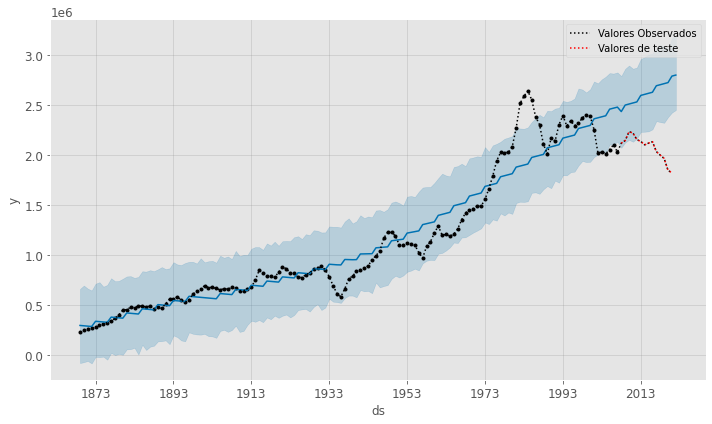

In [84]:
# Plot das previsões
f = plt.figure(figsize = (16,10))
fig = modelo_prophet.plot(forecast_modelo_prophet)
plt.plot(df.index, df.y.values, label = 'Valores Observados', color = 'black', linestyle='dotted')
plt.plot(df[139:].index, df.y[139:].values, label = 'Valores de teste', color = 'red', linestyle='dotted')
plt.legend()

In [80]:
# As previsões do Prophet retornam diversos valores:
forecast_modelo_prophet.shape

(154, 16)

In [81]:
df.shape

(153, 1)

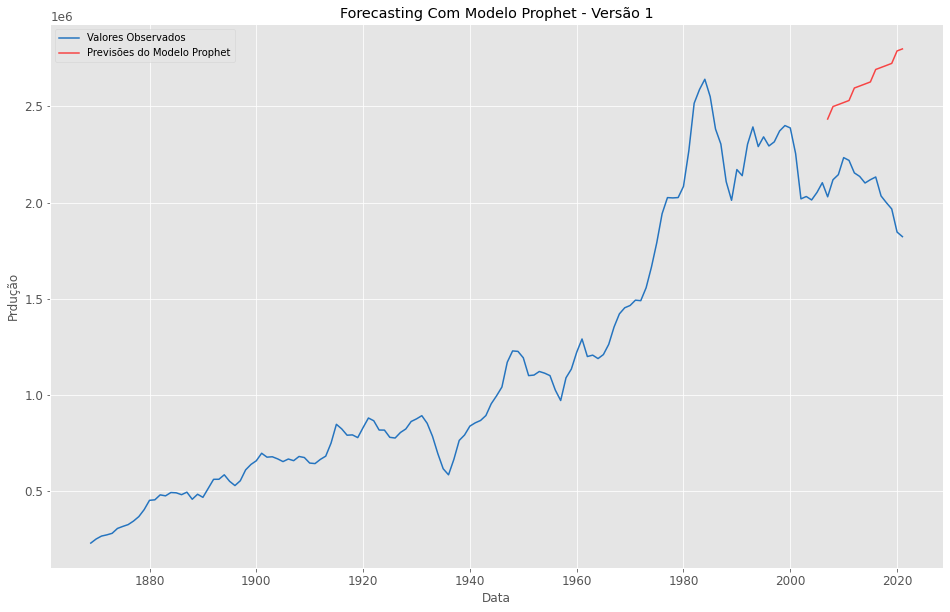

In [82]:
# Plot
f = plt.figure(figsize = (16,10))
# Série original
plt.plot(df.index, 
         df.y.values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões
plt.plot(df[138:].index, 
         forecast_modelo_prophet['yhat'][139:].values,
         label = 'Previsões do Modelo Prophet', 
         alpha = 0.7, 
         color = 'red')

# Limites de Confiança
#plt.fill_between(df[140:].index,
#                forecast_modelo_prophet['yhat_lower'][141:].values,
#                forecast_modelo_prophet['yhat_upper'][141:].values, 
#                color = 'k', 
#                alpha = 0.1)

plt.title('Forecasting Com Modelo Prophet - Versão 1')
plt.xlabel('Data')
plt.ylabel('Prdução')
plt.legend()
plt.show()

In [83]:
# avaliação das previsões
performance(df.y[138:], forecast_modelo_prophet['yhat'][139:].values)

MSE das previsões é 349496572774.73
RMSE das previsões é 591182.35
MAPE das previsões é 0.27


O método autoregressivo desenvolvido neste projeto se mostrou muito mais preciso e confiável do que o método automático proposto pelo algoritmo Prophet.